In [145]:
#Imports
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

In [123]:
#Deze functie wordt gebruikt om inline the image te kunnen tonen
def plot_with_matlib(image):
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(rgb_image)

# Exercise 1
Write a simple camera simulator that projects a 3D wireframe model to image coordinates.

## Question 1: What is the camera matrix for a 1080p camera with a horizontal field of view of 90 degrees?

So for a 1080p camera the dimensions would be (1920,1080). The camera calibration matrix has a form of:<br>
|f_x 0 p_x|<br>
|0 f_y p_y|<br>
|0 0    1 |<br>

f_x = the horizontal focal length<br>
f_y = the vertical focal length<br>

For a 1080p camera f_x = f_y:<br>
f_x = width / (2* tan(theta / 2))<br>
    = 1920 / (2 * tan(90/2))<br>
    = 1920 / (2*1)<br>
    = 960<br>

We assume that the principal point is in the center of the camera so: (960, 540)

So the result matrix would be:<br>
|960  0  960|<br>
| 0  960 540|<br>
| 0   0   1 |<br>


## Assignment 1:
- Create a virtual 3D cube with a side of 1 meter, defined as an 8x3 matrix containing the 3D coordinates
of the vertices of the cube relative to the camera (you can choose the exact position, picture the situation
in your head or make a quick freehand diagram), and a 12x2 array of edges described by pairs of vertex
indices that need to be connected by lines

![Cube drawing](./Images/Cube_image_lab3.png)

In [124]:
# Vertices
vertices = np.array([[1,1,1],[2,1,1],[1,2,1],[2,2,1],[1,2,2],[2,2,2],[1,1,2],[2,1,2]])

# Edges
edges = np.array([
    [0,1],[1,3],[3,2],[2,0], #front face
    [4,5],[5,7],[7,6],[6,4], #back face
    [2,4],[3,5],[1,7],[0,6] #connections of front and back
])


- Project the 3D vertex coordinates to 2D image coordinates using your camera matrix from Question
1, and visualize the result by drawing the vertices and edges on an empty 1080p image. Pay attention
to the dimensions of your matrices, transpose as necessary and round the image coordinates to integer
pixels.

used: https://ksimek.github.io/2013/08/13/intrinsic/

In [125]:
#Re-usable function 
def create_camera_matrix(res:tuple,fov:int) -> np.array:
    # Calculate the focal length in pixels using the horizontal FOV
    focal_length_pixels = res[0] / (2*np.tan(fov / 2))
    # Calculate the camera matrix
    fx = fy = focal_length_pixels
    cx = res[0] / 2
    cy = res[1] / 2
    camera_matrix = np.array([[fx, 0, cx],
                            [0, fy, cy],
                            [0, 0, 1]])
    
    return camera_matrix

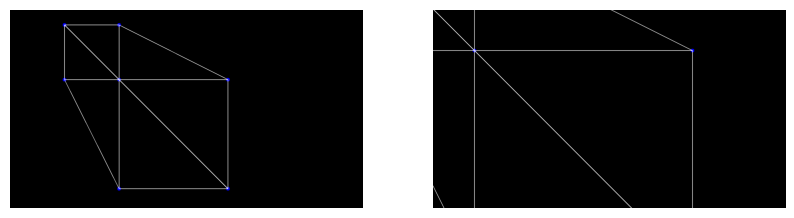

In [132]:
resolution = (1920, 1080)  # 1080p resolution
fov_horizontal_degrees = 90 

K = create_camera_matrix(resolution,fov_horizontal_degrees)
K_double = K.copy()
K_double[0][0] *=2
K_double[1][1] *= 2

image_coord = np.dot(K,vertices.T).T
image_coord2 = np.dot(K_double,vertices.T).T

for i in range(image_coord.shape[0]):
    image_coord[i, 0] /= image_coord[i, 2]  # Normalize x-coordinate
    image_coord2[i, 0] /= image_coord2[i, 2]  # Normalize x-coordinate
    image_coord[i, 1] /= image_coord[i, 2]  # Normalize y-coordinate
    image_coord2[i, 1] /= image_coord2[i, 2]  # Normalize y-coordinate
    
image_coord = np.round(image_coord[:, :2]).astype(int)
image_coord2 = np.round(image_coord2[:, :2]).astype(int)

image = np.zeros((1080, 1920, 3), dtype=np.uint8)
image2 = np.zeros((1080, 1920, 3), dtype=np.uint8)
translate = np.array([960,750])
image_coord -= translate
image_coord2 -= translate*2

for point in image_coord:
    cv.circle(image, tuple(point), 10, (0, 0, 255), -1)
    
for point in image_coord2:
    cv.circle(image2, tuple(point), 10, (0, 0, 255), -1)

for edge in edges:
    cv.line(image, tuple(image_coord[edge[0]]), tuple(image_coord[edge[1]]), (255, 255, 255), 2)
    cv.line(image2, tuple(image_coord2[edge[0]]), tuple(image_coord2[edge[1]]), (255, 255, 255), 2)

fig = plt.figure(figsize=(10,7))

fig.add_subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
fig.add_subplot(1,2,2)
plt.imshow(image2)
plt.axis('off')

plt.show()
     

## Question 2: If you double the focal distance, what happens to the picture?

You zoom in. Meaning here your image doubles in size.

## Question 3: Why are there only even powers in this polynomial in r?

# Exercise 2

## Assignment 2: Determine the intrinsic matrix and distortion parameters of the gopro camera used to shoot the calibration sequence you find on Ufora as calibration frames.zip. 
Print the matrix and coefficients in your report.

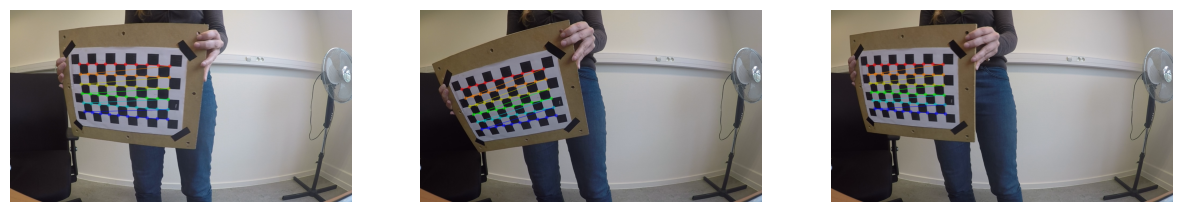

In [163]:
grid = (11,7)
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros(((grid[0]-1)*(grid[1]-1),3), np.float32)
objp[:,:2] = np.mgrid[0:grid[1]-1,0:grid[0]-1].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = os.listdir("./calibration_frames/")

count = 0

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
for fname in images:
    img = cv.imread(f"./calibration_frames/{fname}")
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (grid[0]-1, grid[1]-1), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        if count >1 and count  < 5:
            cv.drawChessboardCorners(img, (grid[0]-1, grid[1]-1), corners2, ret)
            axs[count-2].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            axs[count-2].axis('off')
        count += 1

plt.show()

In [164]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)


[[1.72844461e+02 0.00000000e+00 6.39500000e+02]
 [0.00000000e+00 2.34684400e+03 3.59500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [166]:
print(mtx)
print(dist)

[[1.72844461e+02 0.00000000e+00 6.39500000e+02]
 [0.00000000e+00 2.34684400e+03 3.59500000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-1.47892676e-02  4.68905309e-05 -6.21027527e-05  2.23907748e-03
  -4.00587065e-08]]


## Assignment 3: Do the calibration procedure for different random subsets of 20 frames. Print the standard deviation across these calibration experiments on each of the parameters

In [170]:

# Function to perform calibration and return the parameters
def calibrate(images, grid, criteria, objp):
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    for fname in images:
        img = cv.imread(f"./calibration_frames/{fname}")
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (grid[0]-1, grid[1]-1), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)
    # Perform calibration
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

# Parameters
grid = (11, 7)
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros(((grid[0]-1)*(grid[1]-1), 3), np.float32)
objp[:,:2] = np.mgrid[0:grid[1]-1,0:grid[0]-1].T.reshape(-1,2)
images = os.listdir("./calibration_frames/")

# Number of calibration experiments
num_experiments = 10
param_list = []

for _ in range(num_experiments):
    # Randomly select 20 frames
    selected_images = np.random.choice(images, 20, replace=False)
    ret, mtx, dist, rvecs, tvecs = calibrate(selected_images, grid, criteria, objp)
    param_list.append((ret, mtx, dist, rvecs, tvecs))

# Calculate standard deviation for each parameter
std_dev = [np.std([param[i] for param in param_list], axis=0) for i in range(len(param_list[0]))]

print("Standard deviation across calibration experiments:")
print("ret:", std_dev[0])
print("Camera matrix (mtx):", std_dev[1])
print("Distortion coefficients (dist):", std_dev[2])
print("Rotation vectors (rvecs):", std_dev[3])
print("Translation vectors (tvecs):", std_dev[4])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.